In [1]:
import numpy as np
import rasterio
import matplotlib.pyplot as plt

In [2]:
tiff1 = '2025-02-11-00_00_2025-02-11-23_59_Sentinel-2_L2A_True_color.tiff'
tiff2 = '2025-02-11-00_00_2025-02-11-23_59_Sentinel-2_L2A_False_color.tiff'

In [3]:
with rasterio.open(tiff1) as src1:
    band2 = src1.read(1)
    band3 = src1.read(2)
    band4 = src1.read(3)

with rasterio.open(tiff2) as src2:
    band8 = src2.read(3)

In [4]:
image = np.stack([band3, band4, band2, band8], axis=-1)

In [5]:
print(image.shape)

(1243, 2500, 4)


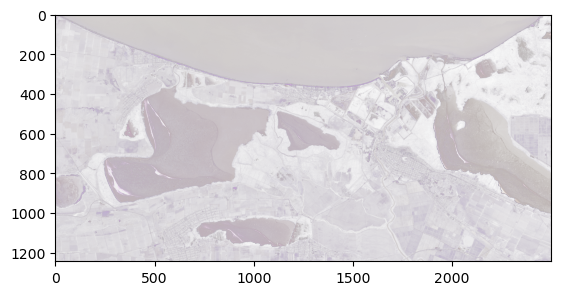

In [6]:
plt.imshow(image)

Выделю по 3 объекта каждого класса. Границы каждого объекта определены 5-ю точками.
- 0-2: Вода
- 3-5: Город
- 6-8: Поля
- 9-11: Камыш

In [13]:
points = []

In [88]:
%matplotlib qt

plt.figure(figsize=(10, 8))
plt.imshow(image)

selected_points = plt.ginput(n=-1, timeout=0)
plt.close()

points.append([(int(x), int(y)) for x, y in selected_points])
print("Выбранные точки:", selected_points)


qt.glx: qglx_findConfig: Failed to finding matching FBConfig for QSurfaceFormat(version 2.0, options QFlags<QSurfaceFormat::FormatOption>(), depthBufferSize -1, redBufferSize 1, greenBufferSize 1, blueBufferSize 1, alphaBufferSize -1, stencilBufferSize -1, samples -1, swapBehavior QSurfaceFormat::SingleBuffer, swapInterval 1, colorSpace QSurfaceFormat::DefaultColorSpace, profile  QSurfaceFormat::NoProfile)
No XVisualInfo for format QSurfaceFormat(version 2.0, options QFlags<QSurfaceFormat::FormatOption>(), depthBufferSize -1, redBufferSize 1, greenBufferSize 1, blueBufferSize 1, alphaBufferSize -1, stencilBufferSize -1, samples -1, swapBehavior QSurfaceFormat::SingleBuffer, swapInterval 1, colorSpace QSurfaceFormat::DefaultColorSpace, profile  QSurfaceFormat::NoProfile)
Falling back to using screens root_visual.


Выбранные точки: [(333.421370967742, 949.2247563844086), (266.21706989247315, 720.3101058467741), (208.46337365591404, 698.2586945564516), (127.6081989247312, 791.7146757392472), (218.96404569892474, 897.7714633736559)]


In [11]:
selected_classes = {
    "Water": points[0:3],
    "City": points[3:6],
    "Fields": points[6:9],
    "Reeds": points[9:12]
}

In [16]:
training_data = {}
for class_name, class_points in selected_classes.items():
    pixels = []
    for point_group in class_points:
        for x, y in point_group:
            pixel_values = image[y, x]
            pixels.append(pixel_values)
    training_data[class_name] = np.array(pixels)

for class_name, data in training_data.items():
    print(f"{class_name}: {data.shape} точек с {data.shape[1]} каналами")

Water: (15, 4) точек с 4 каналами
City: (15, 4) точек с 4 каналами
Fields: (15, 4) точек с 4 каналами
Reeds: (15, 4) точек с 4 каналами


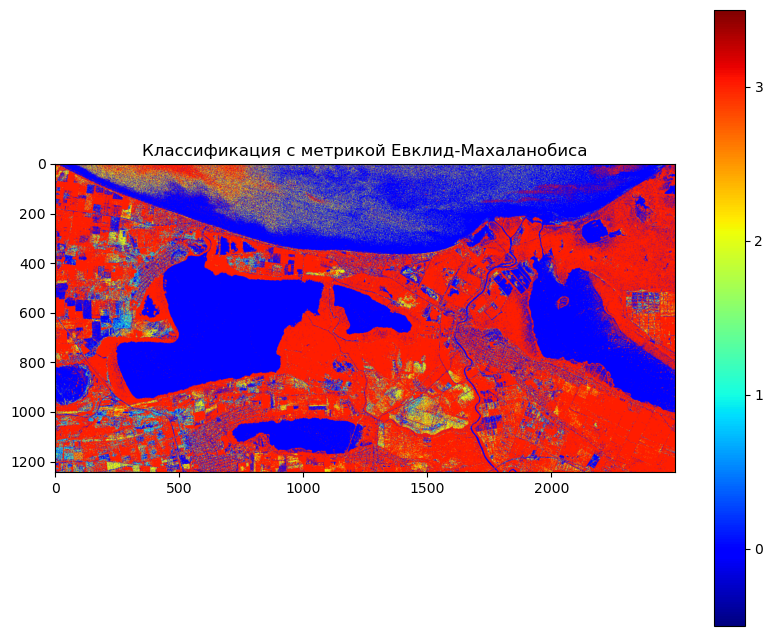

In [19]:
stats = {}
for class_name, data in training_data.items():
    mean = np.mean(data, axis=0)
    cov = np.cov(data, rowvar=False)
    E = np.eye(cov.shape[0]) * 1e-6
    combined_cov = cov + E
    inv_cov = np.linalg.inv(combined_cov)
    stats[class_name] = {'mean': mean, 'inv_cov': inv_cov}

def euclidean_mahalanobis_distance(point, mean, inv_cov):
    diff = point - mean
    return np.sqrt(diff.T @ inv_cov @ diff)

height, width, _ = image.shape
classified_image = np.zeros((height, width), dtype=np.uint8)

for y in range(height):
    for x in range(width):
        pixel = image[y, x]
        distances = {}
        for class_name in stats:
            dist = euclidean_mahalanobis_distance(pixel, stats[class_name]['mean'],
                                                  stats[class_name]['inv_cov'])
            distances[class_name] = dist
        predicted_class = min(distances, key=distances.get)
        class_index = list(selected_classes.keys()).index(predicted_class)
        classified_image[y, x] = class_index

plt.figure(figsize=(10, 8))
plt.imshow(classified_image, cmap='jet')
plt.colorbar(ticks=range(len(selected_classes)))
plt.clim(-0.5, len(selected_classes) - 0.5)
plt.title("Классификация с метрикой Евклид-Махаланобиса")
plt.show()